In [28]:
# Q1 libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
sns.set(style="whitegrid")

# 1. Generate dataset with 8 highly correlated features
np.random.seed(42)
n_samples = 1000
# generate a base signal
base = np.random.normal(0, 1, size=(n_samples, 1))
# create 8 features as base plus small noise -> highly correlated
X = np.hstack([base + np.random.normal(0, 0.01*i, size=(n_samples,1)) for i in range(1,9)])
# True coefficients (some nonzero)
true_w = np.array([3.5, -1.2, 0.8, 0, 2.0, 0, -0.5, 1.1])
y = X.dot(true_w) + np.random.normal(0, 0.5, size=n_samples)  # add noise

# turn into DataFrame for convenience
cols = [f"X{i+1}" for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=cols)
df['y'] = y
df.head()


,X1,X2,X3,X4,X5,X6,X7,X8,y
0,0.510708,0.483211,0.439480,0.462174,0.475526,0.429869,0.551677,0.494072,3.160602
1,-0.129018,-0.141155,-0.164076,-0.139512,-0.160935,-0.176120,-0.262702,-0.178556,-0.263663
2,0.648285,0.631840,0.635280,0.648409,0.557906,0.591165,0.697721,0.633899,3.732599
3,1.516560,1.516871,1.579660,1.541935,1.506525,1.490150,1.506669,1.580208,7.778142
4,-0.227171,-0.272026,-0.217457,-0.288828,-0.197512,-0.247002,-0.184631,-0.131925,-1.168170


In [29]:
# Standardize inputs (important for gradient descent with regularization)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[cols])
y = df['y'].values.reshape(-1,1)

# add bias term inside gradient descent by augmenting X
X_aug = np.hstack([np.ones((X_scaled.shape[0],1)), X_scaled])  # shape (n, p+1)

def ridge_gd(X, y, alpha=0.01, reg=1.0, n_iter=1000):
    # X: (n, p) includes bias column; w shape (p,1)
    n, p = X.shape
    w = np.zeros((p,1))
    lr = alpha
    costs = []
    for i in range(n_iter):
        preds = X.dot(w)
        error = preds - y
        # note: do NOT regularize bias (w[0])
        grad = (2/n)*X.T.dot(error)
        reg_term = (2*reg/n)*w
        reg_term[0] = 0.0
        grad = grad + reg_term
        w = w - lr*grad
        cost = (1/n)*(error**2).sum() + reg*(w[1:]**2).sum()  # ridge cost (excluding bias)
        costs.append(cost)
    return w, costs

# quick test (single run)
w_test, costs_test = ridge_gd(X_aug, y, alpha=0.01, reg=1.0, n_iter=2000)
print("Final MSE:", costs_test[-1])


Final MSE: 4.230990019407915


In [30]:
# hyperparams to search
# Adjusted learning rates to prevent divergence
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05] # Reduced max learning rate
reg_params = [10**(-15), 10**(-10), 10**(-5), 10**(-3), 0, 1, 10, 20]

results = []
n_iter = 2000

for lr in learning_rates:
    for reg in reg_params:
        w, costs = ridge_gd(X_aug, y, alpha=lr, reg=reg, n_iter=n_iter)
        preds = X_aug.dot(w).flatten()
        # Check for NaN or inf in predictions before calculating metrics
        if not np.any(np.isnan(preds)) and not np.any(np.isinf(preds)):
            r2 = r2_score(y, preds)
            mse = mean_squared_error(y, preds)
            results.append({
                'lr': lr, 'reg': reg, 'r2': r2, 'mse': mse, 'final_cost': costs[-1]
            })
        else:
             # Handle cases where training failed (e.g., add a placeholder or skip)
            results.append({
                'lr': lr, 'reg': reg, 'r2': np.nan, 'mse': np.nan, 'final_cost': np.nan
            })


res_df = pd.DataFrame(results)
# sort to find best by r2 and by smallest cost
best_by_r2 = res_df.sort_values('r2', ascending=False).iloc[0]
best_by_cost = res_df.sort_values('final_cost', ascending=True).iloc[0]
best_by_r2, best_by_cost

(lr            0.050000
 reg           0.000000
 r2            0.992438
 mse           0.237618
 final_cost    0.237621
 Name: 44, dtype: float64,
 lr            0.050000
 reg           0.000000
 r2            0.992438
 mse           0.237618
 final_cost    0.237621
 Name: 44, dtype: float64)

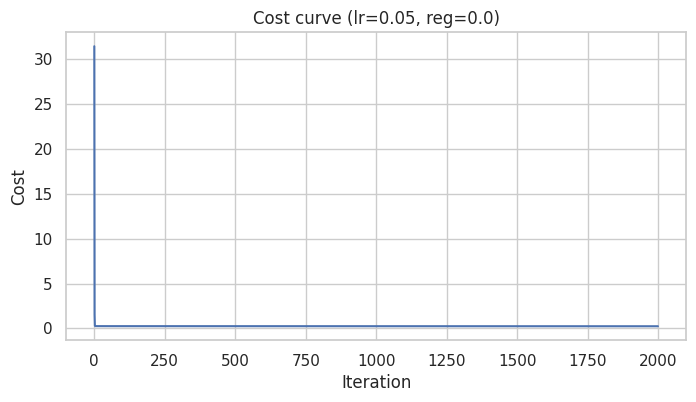

Best config (by R2): {'lr': 0.05, 'reg': 0.0, 'r2': 0.9924383110429201, 'mse': 0.23761833718480432, 'final_cost': 0.23762078853851434}


In [31]:
# re-run GD to get cost curve for best_r2 combination
best_lr = best_by_r2['lr']
best_reg = best_by_r2['reg']
w_best, costs_best = ridge_gd(X_aug, y, alpha=best_lr, reg=best_reg, n_iter=2000)

plt.figure(figsize=(8,4))
plt.plot(costs_best)
plt.title(f"Cost curve (lr={best_lr}, reg={best_reg})")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

print("Best config (by R2):", best_by_r2.to_dict())


In [32]:
import os
print(os.listdir('.'))


['.config', '.ipynb_checkpoints', 'Hitters (1).csv', 'sample_data']


In [33]:
# load the Hitters dataset into a pandas DataFrame
import pandas as pd

hitters = pd.read_csv('/content/Hitters (1).csv')
display(hitters.head())

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [34]:
# 1. handle NaNs
print("Null counts:\n", hitters.isnull().sum())

# common in Hitters: 'Salary' may have NaNs; remove rows with NaN target or fill
# If Salary is target, drop rows with missing target
if 'Salary' in hitters.columns:
    hitters = hitters.dropna(subset=['Salary'])

# For other numeric nulls, either impute median or drop rows
hitters = hitters.fillna(hitters.median(numeric_only=True))

# Convert categorical columns to numeric (one-hot)
cat_cols = hitters.select_dtypes(include=['object','category']).columns.tolist()
hitters_enc = pd.get_dummies(hitters, columns=cat_cols, drop_first=True)

hitters_enc.head()


Null counts:
 AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,True,True,True
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,False,True,False
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0,True,False,True
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5,True,False,True
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0,False,True,False


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# target
target = 'Salary'  # if assignment expects Salary
X = hitters_enc.drop(columns=[target])
y = hitters_enc[target].values

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaling
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


In [36]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

alpha_val = 0.5748

lr_model = LinearRegression()
ridge_model = Ridge(alpha=alpha_val)
lasso_model = Lasso(alpha=alpha_val, max_iter=10000)

lr_model.fit(X_train_s, y_train)
ridge_model.fit(X_train_s, y_train)
lasso_model.fit(X_train_s, y_train)


Lasso(alpha=0.5748, max_iter=10000)

In [37]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

models = {'Linear': lr_model, 'Ridge': ridge_model, 'Lasso': lasso_model}
evals = []
for name, model in models.items():
    preds = model.predict(X_test_s)
    evals.append({
        'model': name,
        'r2': r2_score(y_test, preds),
        'mse': mean_squared_error(y_test, preds),
        'mae': mean_absolute_error(y_test, preds)
    })

pd.DataFrame(evals).set_index('model')


,r2,mse,mae
model,,,
Linear,0.290745,128284.345497,211.115962
Ridge,0.300036,126603.902644,204.664174
Lasso,0.299626,126678.116040,206.077359


In [38]:
# Q3: Cross validation for RidgeCV and LassoCV
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV

# load Boston
try:
    from sklearn.datasets import load_boston
    b = load_boston()
    X_b, y_b = b.data, b.target
except Exception as e:
    # fallback via openml
    from sklearn.datasets import fetch_openml
    b = fetch_openml(name='boston', version=1, as_frame=False)
    X_b, y_b = b.data, b.target.astype(float)

# Split
Xtr, Xte, ytr, yte = train_test_split(X_b, y_b, test_size=0.2, random_state=42)

# scale
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
Xtr_s = sc.fit_transform(Xtr)
Xte_s = sc.transform(Xte)

# RidgeCV
alphas = np.logspace(-4, 4, 50)
ridgecv = RidgeCV(alphas=alphas, store_cv_values=True)
ridgecv.fit(Xtr_s, ytr)
best_alpha_ridge = ridgecv.alpha_

# LassoCV
lassocv = LassoCV(alphas=None, cv=5, max_iter=10000)
lassocv.fit(Xtr_s, ytr)
best_alpha_lasso = lassocv.alpha_

print("RidgeCV best alpha:", best_alpha_ridge)
print("LassoCV best alpha:", best_alpha_lasso)

# Evaluate
from sklearn.metrics import r2_score, mean_squared_error
for name, model in [("RidgeCV", ridgecv), ("LassoCV", lassocv)]:
    preds = model.predict(Xte_s)
    print(name, "R2:", r2_score(yte, preds), "MSE:", mean_squared_error(yte, preds))


RidgeCV best alpha: 7.9060432109076855
LassoCV best alpha: 0.006863892263379676
RidgeCV R2: 0.6665041944957998 MSE: 24.45650908572226
LassoCV R2: 0.6683883969336304 MSE: 24.31833339271624


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


In [39]:
# Q4: Multiclass Logistic Regression (OvR) on Iris
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

data = load_iris()
X = data.data
y = data.target
class_names = data.target_names

# scale and split
sc = StandardScaler()
X_s = sc.fit_transform(X)
Xtr, Xte, ytr, yte = train_test_split(X_s, y, test_size=0.2, random_state=42, stratify=y)

# Logistic regression helper functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_gd(X, y_binary, lr=0.1, n_iter=2000):
    # add bias
    X_aug = np.hstack([np.ones((X.shape[0],1)), X])
    n, p = X_aug.shape
    w = np.zeros((p,1))
    yb = y_binary.reshape(-1,1)
    for i in range(n_iter):
        preds = sigmoid(X_aug.dot(w))
        grad = (1/n) * X_aug.T.dot(preds - yb)
        w = w - lr*grad
    return w

# Train one-vs-rest classifiers
unique_classes = np.unique(ytr)
weights = {}
for cls in unique_classes:
    y_binary = (ytr == cls).astype(int)
    w_cls = logistic_gd(Xtr, y_binary, lr=0.5, n_iter=3000)
    weights[cls] = w_cls

# Predict function
def predict_ovr(X):
    X_aug = np.hstack([np.ones((X.shape[0],1)), X])
    scores = np.hstack([X_aug.dot(weights[cls]) for cls in sorted(weights.keys())])  # (n, n_classes)
    # pick class with highest score (logit)
    preds = np.argmax(scores, axis=1)
    return preds

y_pred = predict_ovr(Xte)
print("Accuracy:", accuracy_score(yte, y_pred))
print("Classification report:\n", classification_report(yte, y_pred, target_names=class_names))
print("Confusion matrix:\n", confusion_matrix(yte, y_pred))


Accuracy: 0.9333333333333333
Classification report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

Confusion matrix:
 [[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]
